In [142]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

# FUNÇÃO DE TRANSFERÊNCIA DO CONTROLADOR

In [143]:
s = sp.symbols('s')
K, a, b = (3.715724935236598, -1.5593107447962538, -0.15218921491137669)

C = K * (s - a) * (s - b) / s
C

(s + 0.152189214911377)*(3.7157249352366*s + 5.79396981622179)/s

- O controlador é passado para o domínio discreto $z$ quando $s \to \frac{2}{T} \cdot \frac{z-1}{z+1}$

In [144]:
T = 0.15
z = sp.symbols('z')

transZ = 2/T*(z-1)/(z+1)
C = C.subs(s, transZ).expand().simplify()
C

(55.9685956922464*z**4 - 98.9537313153433*z**3 - 12.7189261538842*z**2 + 98.9537313153433*z - 43.2496695383622)/(1.0*z**4 - 2.0*z**2 + 1.0)

- Substituindo $C(s) = \frac{Y(s)}{X(s)}$ (saída sobre a entrada)

In [145]:
X, Y = sp.symbols('X Y')
sp.Eq(Y/X, C)

Eq(Y/X, (55.9685956922464*z**4 - 98.9537313153433*z**3 - 12.7189261538842*z**2 + 98.9537313153433*z - 43.2496695383622)/(1.0*z**4 - 2.0*z**2 + 1.0))

- O próximo passo é dividir tudo pelo termos de maior grau do denominador, ou seja, por $z^4$, e vamos também expandir pra manipular melhor

In [146]:
num, den = sp.fraction(C)
grau = sp.Poly(den).degree()
grau

4

In [147]:
eq = sp.Eq((num*X/z**grau).expand() - (den*Y/z**grau).expand(), 0)
eq

Eq(55.9685956922464*X - 98.9537313153433*X/z - 12.7189261538842*X/z**2 + 98.9537313153433*X/z**3 - 43.2496695383622*X/z**4 - 1.0*Y + 2.0*Y/z**2 - 1.0*Y/z**4, 0)

- Agora dentro deste $\textbf{for}$ serão feitas substituições do tipo $2Y\,z^{-2} = 2Y_{n-2}$

In [148]:
for i in range(10, 0, -1):
    eq = eq.subs(X/z**i, sp.symbols('X_{n-' + str(i) + '}'))
    eq = eq.subs(Y/z**i, sp.symbols('Y_{n-' + str(i) + '}'))

eq

Eq(55.9685956922464*X - 98.9537313153433*X_{n-1} - 12.7189261538842*X_{n-2} + 98.9537313153433*X_{n-3} - 43.2496695383622*X_{n-4} - 1.0*Y + 2.0*Y_{n-2} - 1.0*Y_{n-4}, 0)

- Agora é só isolar o $Y = Y_n$

In [149]:
sol = sp.Eq(Y, sp.solve(eq, Y)[0])
sol

Eq(Y, 55.9685956922464*X - 98.9537313153433*X_{n-1} - 12.7189261538842*X_{n-2} + 98.9537313153433*X_{n-3} - 43.2496695383622*X_{n-4} + 2.0*Y_{n-2} - Y_{n-4})

- Formatando as variáveis para ficar mais fácil de copiar e colar no arduino

In [150]:
Y_n = sol.rhs
Y_n = Y_n.subs(sp.symbols('X'), sp.symbols('X_n'))

Y_str = str(Y_n)
Y_str = Y_str.replace('X_{n-1}', 'X_n1').replace('X_{n-2}', 'X_n2').replace('X_{n-3}', 'X_n3').replace('X_{n-4}', 'X_n4')\
             .replace('Y_{n-1}', 'Y_n1').replace('Y_{n-2}', 'Y_n2').replace('Y_{n-3}', 'Y_n3').replace('Y_{n-4}', 'Y_n4') + ';'

print(Y_str)

55.9685956922464*X_n - 98.9537313153433*X_n1 - 12.7189261538842*X_n2 + 98.9537313153433*X_n3 - 43.2496695383622*X_n4 + 2.0*Y_n2 - Y_n4;


# TESTANDO O CONTROLADOR

In [151]:
Y_n1 = Y_n2 = Y_n3 = Y_n4 = 0
X_n1 = X_n2 = X_n3 = X_n4 = 0

def computeController(inputValue, setpoint):
    global Y_n1, Y_n2, Y_n3, Y_n4
    global X_n1, X_n2, X_n3, X_n4
    
    X_n = setpoint - inputValue
    Y_n = eval(Y_str[:-1])

    if Y_n < -100:
        Y_n = -100

    if Y_n > 100:
        Y_n = 100

    X_n4 = X_n3
    X_n3 = X_n2
    X_n2 = X_n1
    X_n1 = X_n 

    Y_n4 = Y_n3
    Y_n3 = Y_n2
    Y_n2 = Y_n1
    Y_n1 = Y_n
    return Y_n

In [152]:
timeData = np.arange(0, 10, T)

- O comportamento normal é que, se o output estiver menor do que o setpoint, o erro é positivo, o controlador então deve aumentar a saída até a saturação.

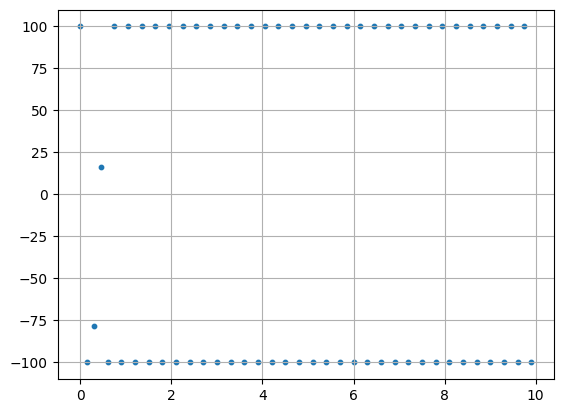

In [153]:
setpoint     = 10
currentInput = 5

inputData  = [currentInput for i in timeData]
outputData = [computeController(inputVal, setpoint) for inputVal in inputData]

plt.scatter(timeData, outputData, s=10)
plt.grid()
plt.show()

- O comportamento normal é que, se o output estiver maior do que o setpoint, o erro é negativo, o controlador então deve diminuir a saída até a saturação.

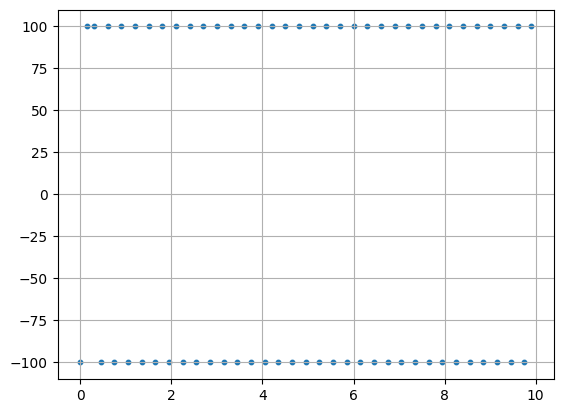

In [154]:
setpoint     = 10
currentInput = 15

inputData  = [currentInput for i in timeData]
outputData = [computeController(inputVal, setpoint) for inputVal in inputData]

plt.scatter(timeData, outputData, s=10)
plt.grid()
plt.show()

- Se o setpoint é igual o input, o erro é zero, o atuador deve manter a saída inalterada, ou seja, permanecer constante

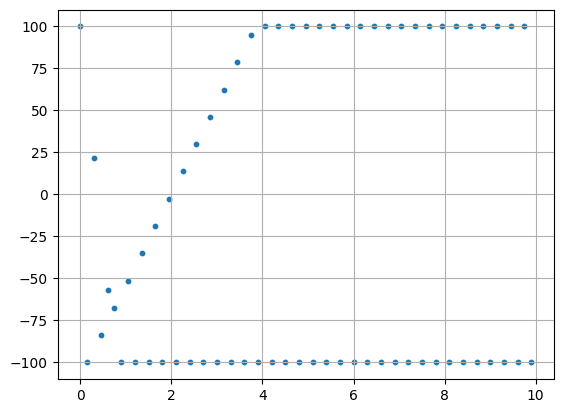

In [155]:
setpoint     = 10
currentInput = 10

inputData  = [currentInput for i in timeData]
outputData = [computeController(inputVal, setpoint) for inputVal in inputData]

plt.scatter(timeData, outputData, s=10)
plt.grid()
plt.show()